# On the Causes and Environmental Impact of Airborne Holdings at Major European Airports

We recommend to install the libraries in the requirements.txt.
You can do so by running the following (commented) cell.

In [ ]:
#%pip install -r requirements.txt

---

### Load libraries

In [ ]:
from pandas import read_csv, Series, concat
from pathlib import Path 
from numpy import where, mean
from typing import Optional, Tuple
from numpy import where
from lightgbm import LGBMClassifier
from sklearn.cluster import Birch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score
from shap import TreeExplainer, Explanation
from shap.plots import beeswarm
from matplotlib.axes import Axes
import matplotlib.pyplot as plt 
import seaborn as sns

Seaborn configuration for LaTeX-like plots

In [3]:
sns.set(
    context="talk",
    style="ticks",
    rc={
        "ytick.right": True,
        "xtick.top": True,
        "font.family": "serif",
        "font.sans-serif": "Computer Modern Sans Serif",
    },
)

---

### Beautiful plot functions

In [4]:
def shap_beeswarm_plot(
    explanation: Explanation, max_display: Optional[int] = 30, figsize: Tuple = (4, 5)
) -> Axes:
    """Shapley beeswarm plot

    Args:
        explanation (Explanation): SHAP explanation
        max_display (Optional[int], optional): maximum # of features to display. Defaults to 30..
        figsize (Tuple, optional): size of the figure. Defaults to (4, 5).

    Returns:
        Axes: axes of the plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    beeswarm(explanation, max_display=max_display, show=False, color_bar=False)
    ax.tick_params(**{"right": False, "top": True})
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.set_xlabel("Shapley Value", fontsize=14)
    fig.set_size_inches(figsize[0], figsize[1])
    plt.xticks(fontsize=14)
    return ax

---

### Configuration

In [6]:
dataset_path = Path("dataset.csv") 
dataset = "real"
model_class = "DT"
threshold = 0.75
max_iter = 250
test_size = 0.1
run_id = "{}_{}".format(dataset, model_class)

clusterer_kwargs = dict(threshold=0.25, n_clusters=7, branching_factor=50)

if model_class == "DT":
    model_kwargs = dict(criterion="gini", max_depth=10, min_samples_leaf=25)
else:
    model_kwargs = dict(
        monotone_constraints_method="advanced",
        n_estimators=60,
        max_depth=10,
        min_data_in_leaf=25,
        num_leaves=16,
    )

palette = {"Unknown": "gray", "Other": "dodgerblue", "Weather": "crimson"}
palette_clusters = {
    "other": "grey",
    "snow": (0.10588235294117647, 0.6196078431372549, 0.4666666666666667, 1.0),
    "thunderstorms": (
        0.8509803921568627,
        0.37254901960784315,
        0.007843137254901933,
        1.0,
    ),
    "clouds": (0.4588235294117647, 0.4392156862745098, 0.7019607843137254, 1.0),
    "speed": (0.9058823529411765, 0.16078431372549018, 0.5411764705882353, 1.0),
    "ceiling": (0.4, 0.6509803921568628, 0.11764705882352944, 1.0),
    "obscuration": (0.9019607843137255, 0.6705882352941176, 0.00784313725490196, 1.0),
}

---


### Load data

load the csv containing the number of flights holding and fuel consumption by interval of 30'. Note that the airport and the time were removed for confidentiality reasons. Fuel consumption was computed using OpenAP.

In [7]:
X = read_csv(dataset_path, index_col=0)

In [8]:
X.head()

,speed,gust,visibility,ceiling,cover,precipitation,obscuration,thunderstorms,snow,clouds,reason,fuel,holding_flights
0,4.12,0.0,9999.0,3048.0,4.0,False,False,False,False,False,NaN,1595.913568,3.0
1,5.14,0.0,9999.0,3048.0,0.0,False,False,False,False,False,NaN,1021.045796,3.0
2,1.54,0.0,9999.0,3048.0,0.0,False,False,False,False,False,NaN,106.671055,1.0
3,2.57,0.0,700.0,61.0,10.0,False,True,False,False,False,NaN,50.580737,1.0
4,2.06,0.0,200.0,61.0,10.0,False,True,False,False,False,NaN,2474.580334,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49150,3.09,0.0,9999.0,3048.0,2.0,False,False,False,False,False,NaN,219.511888,2.0
49151,4.12,0.0,9999.0,3048.0,4.0,False,False,False,False,True,NaN,464.744084,4.0
49152,3.60,0.0,9999.0,3048.0,2.0,False,False,False,False,False,Other,381.742177,2.0
49153,4.12,0.0,9999.0,3048.0,4.0,False,False,False,False,False,NaN,26.965759,1.0


extract the reason (weather or other)

In [9]:
reason = X.pop('reason')

extract also the amount of fuel and the number of holding flights

In [10]:
fuel = X.pop('fuel')
holding_flights = X.pop('holding_flights')

describe of the dataset

In [11]:
X.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49155 entries, 0 to 49154
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   speed          49155 non-null  float64
 1   gust           49155 non-null  float64
 2   visibility     49155 non-null  float64
 3   ceiling        49155 non-null  float64
 4   cover          49155 non-null  float64
 5   precipitation  49155 non-null  bool   
 6   obscuration    49155 non-null  bool   
 7   thunderstorms  49155 non-null  bool   
 8   snow           49155 non-null  bool   
 9   clouds         49155 non-null  bool   
dtypes: bool(5), float64(5)
memory usage: 2.5 MB


In [12]:
numerical_description = X.describe(include="number").round(1).drop(['count', 'max', 'min', 'std']).T

In [13]:
numerical_description

,mean,25%,50%,75%
speed,4.0,2.1,3.6,5.1
gust,0.6,0.0,0.0,0.0
visibility,9242.5,9999.0,9999.0,9999.0
ceiling,2252.4,1067.0,3048.0,3048.0
cover,3.2,0.0,2.0,6.0


In [14]:
categorical_description = X.describe(include="bool").drop(['count']).T

In [15]:
categorical_description['freq'] = categorical_description['freq'] / len(X)

In [16]:
categorical_description

,unique,top,freq
precipitation,2,False,0.867602
obscuration,2,False,0.93787
thunderstorms,2,False,0.984132
snow,2,False,0.986166
clouds,2,False,0.913071


In [17]:
reason.value_counts(dropna=False)

NaN        41620
Other       4051
Weather     3484
Name: reason, dtype: int64

---

### Semi-supervised learning

create the labels from the reason: weather is 1, other is 0, unknown is -1

In [18]:
y = reason.map({'Weather': 1, 'Other': 0}).fillna(-1)

determine the list of features

In [19]:
features = X.columns.tolist()
bool_features = X.select_dtypes(bool).columns.tolist()

keep some observations (10%) for testing purposes

In [20]:
if test_size is not None:
    label_index = y.loc[y != -1].index.tolist()
    _, test_index = train_test_split(
        label_index,
        stratify=y.loc[label_index].tolist(),
        test_size=test_size,
        random_state=42,
    )
    X_test, y_test = X.loc[test_index], y.loc[test_index]
    X_train, y_train = X.drop(test_index), y.drop(test_index)
else:
    X_train, y_train = X.copy(), y.copy()


define the base model (DT or GBDT)

In [23]:
if model_class == "DT":
    model = DecisionTreeClassifier(**model_kwargs)
else:
    monotone_constraints = []
    for f in features:
        if f in bool_features:
            monotone_constraints.append(+1)
        elif f in ["visibility", "ceiling"]:
            monotone_constraints.append(-1)
        else:
            monotone_constraints.append(+1)

    model = LGBMClassifier(
        objective="binary", monotone_constraints=monotone_constraints, **model_kwargs
    )

In [24]:
model

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25)

create the self-training classifier

In [25]:
self_training_model = SelfTrainingClassifier(model, 
                                             threshold=threshold,
                                             verbose=False, 
                                             max_iter=max_iter)

train the self-training classifier

In [26]:
self_training_model.fit(X_train, y_train)

SelfTrainingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                             min_samples_leaf=25),
                       max_iter=250)

In [27]:
print(self_training_model.termination_condition_)

no_change


In [28]:
print(self_training_model.n_iter_)

8


In [29]:
transduction = Series(self_training_model.transduction_, name='reason', index=X_train.index).map({1: 'Weather', 0: 'Other', -1: 'Unknown'})
labeled_iter = Series(self_training_model.labeled_iter_, index=X_train.index, name='labeled_iter')

In [30]:
labeled_reasons = concat([labeled_iter.astype(int), transduction], axis=1)

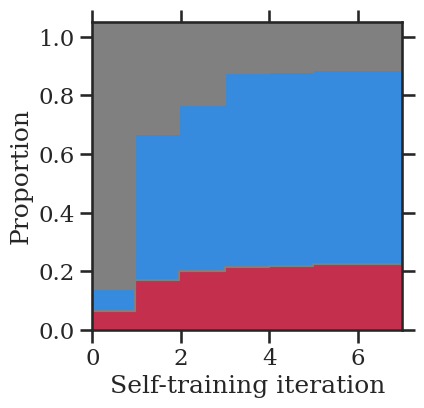

In [31]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(data=labeled_reasons,
             multiple="stack",
             x="labeled_iter",
             ax=ax,
             palette=palette,
             hue="reason",
             element="step", 
             fill=True,
             hue_order=['Unknown','Other', 'Weather'],
             cumulative=True,
             stat="proportion",
             edgecolors=palette['Unknown'],
             legend=False)

_ = ax.set_facecolor(palette['Unknown'])
_ = ax.set_xlabel('Self-training iteration')
_ = ax.set_xlim((0, labeled_iter.max() ))
plt.show()
plt.close()

performance metrics on the test set

In [32]:
if test_size is not None:
    y_hat = self_training_model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_hat > 0.5))
    print("AP: {}".format(round(average_precision_score(y_test, y_hat), 2)))   
    print("ROC AUC: {}".format(round(roc_auc_score(y_test, y_hat), 2)))

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       405
         1.0       0.81      0.79      0.80       349

    accuracy                           0.82       754
   macro avg       0.82      0.82      0.82       754
weighted avg       0.82      0.82      0.82       754

AP: 0.84
ROC AUC: 0.87


calibration plot

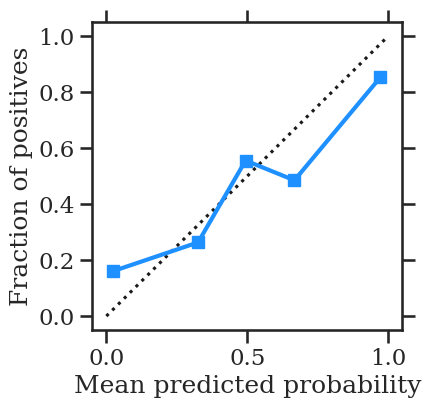

In [33]:
fig, ax = plt.subplots(figsize=(4, 4))
CalibrationDisplay.from_predictions(y_test, y_hat, strategy='uniform', n_bins=5, ax=ax, color='dodgerblue', linewidth=3)
ax.set(xlabel='Mean predicted probability', ylabel='Fraction of positives')
ax.get_legend().remove()
plt.show()
plt.close()

---

### Model interpretation


extract base model

In [34]:
model = self_training_model.base_estimator_

compte shapley values

In [41]:
explainer = TreeExplainer(model, model_output="raw")
shap_values = explainer.shap_values(X)

expected value (prediction of a feature-less model)

In [36]:
base_values = explainer.expected_value

create explanation

In [37]:
if len(base_values) == 1:
    explanation = Explanation(values=shap_values, 
                              data=X.values,
                              base_values=base_values, 
                              feature_names=X.columns.tolist(),
                              output_names="weather logit")    
else:
    explanation = Explanation(values=shap_values[1], 
                              data=X.values,
                              base_values=base_values[1], 
                              feature_names=X.columns.tolist(),
                              output_names="weather logit")    

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


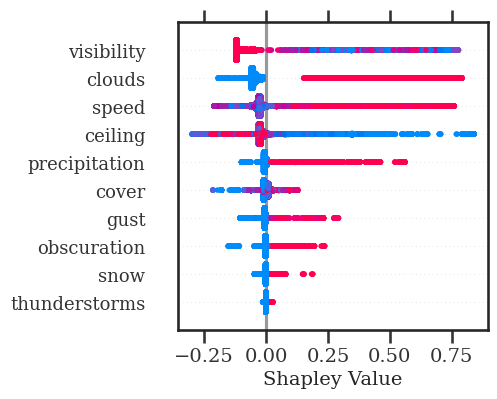

In [38]:
_ = shap_beeswarm_plot(explanation, max_display=30, figsize=(4,4))
plt.show()
plt.close()

### Plot distributions

In [1754]:
reason = reason.fillna(transduction)

In [1755]:
reason.value_counts(dropna=False)

Other      30829
Weather    13618
Unknown     4708
Name: reason, dtype: int64

In [1756]:
reason.value_counts(dropna=False, normalize=True).round(3)

Other      0.627
Weather    0.277
Unknown    0.096
Name: reason, dtype: float64

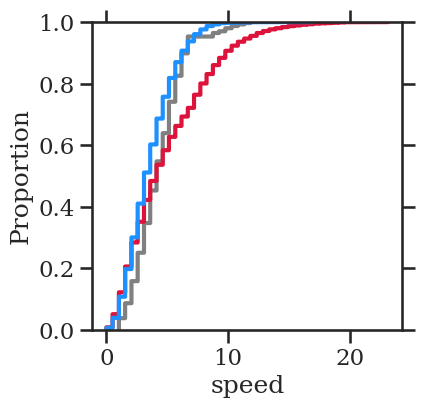

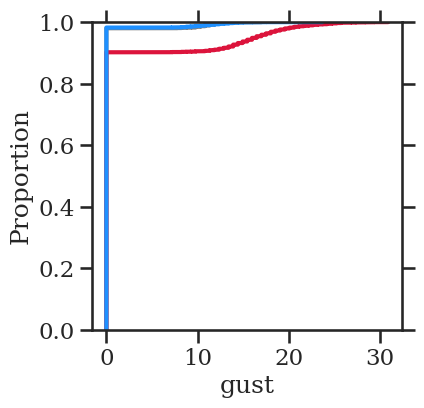

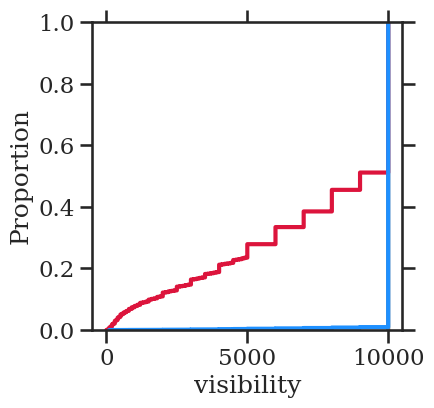

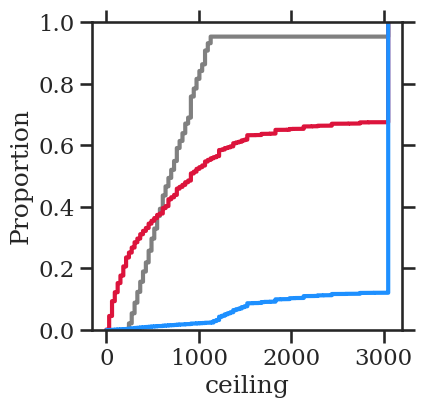

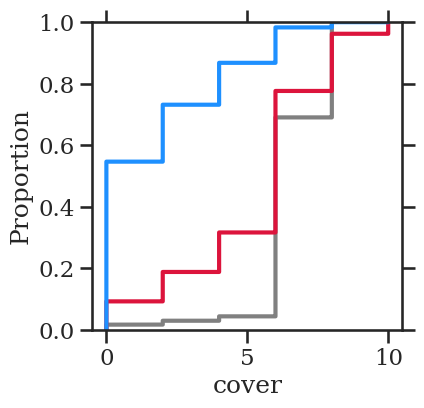

In [1757]:
for c in X.select_dtypes("number"):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = sns.ecdfplot(x=X[c], 
                      hue=reason, 
                      ax=ax, 
                      linewidth=3,
                      legend=False,
                      palette=palette)
    plt.show()
    plt.close()

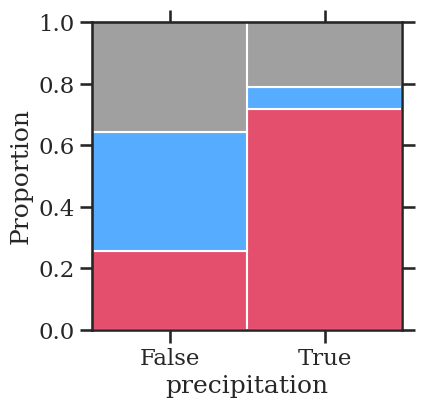

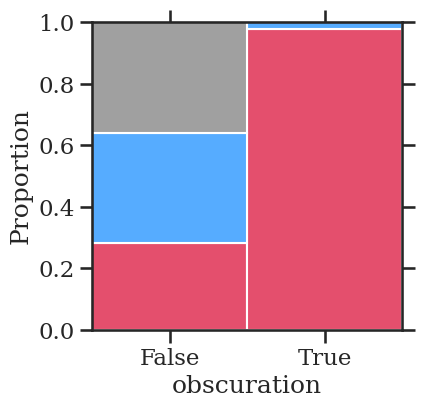

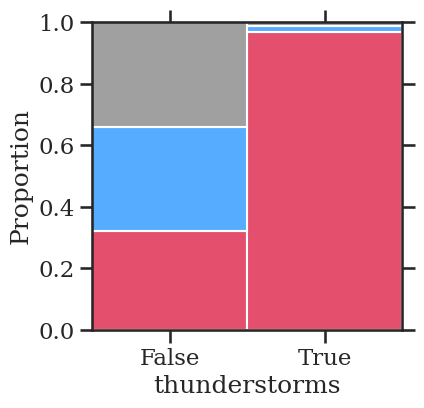

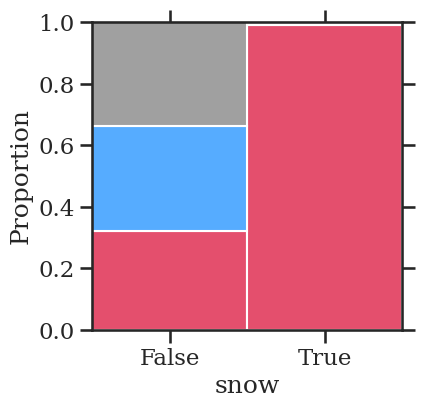

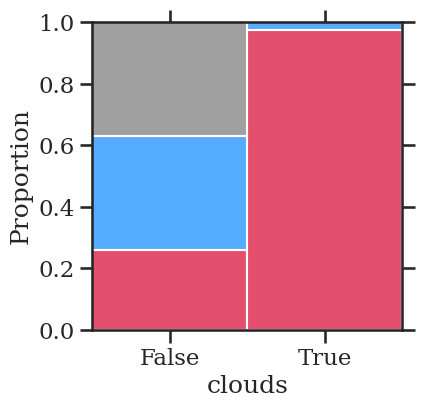

In [1758]:
for c in X.select_dtypes("bool"):
    try:
        fig, ax = plt.subplots(figsize=(4,4))
        ax = sns.histplot(x=X[c].astype(str), 
                          hue=reason, 
                          ax=ax, 
                          multiple='fill',
                          common_norm=False, 
                          hue_order=['Unknown', 'Other', 'Weather'],
                          palette=palette, 
                          legend=False,
                          shrink=True,
                          stat="proportion")
        plt.show()
        plt.close()
    except Exception as e:
        print(e)

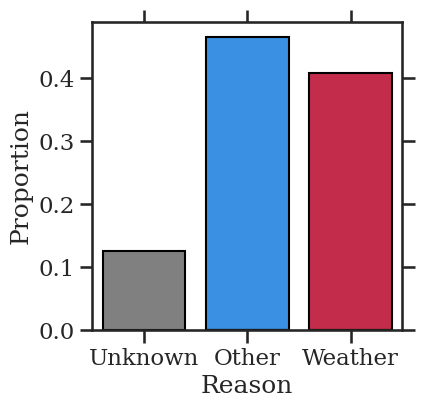

In [1759]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(x=reason,
            y=fuel / fuel.sum(), 
            ax=ax,
            hue=reason,
            order=palette.keys(),
            palette=palette, 
            estimator="sum", 
            dodge=False,
            edgecolor='black',
            errorbar=None)
plt.legend([],[], frameon=False)
ax.set_xlabel('Reason')
ax.set_ylabel('Proportion')
plt.show()
plt.close()

---

## Project and cluster

index of observations labeled (or pseudo-labeled) as weather

In [1760]:
widx = where(reason == 'Weather')[0]

project into two dimensions for visualisation purposes

In [1761]:
pca = PCA(n_components=2)

In [1762]:
components = pca.fit_transform(explanation.values[widx])

In [1763]:
pca.explained_variance_ratio_

array([0.49765446, 0.28336266])

display the projection

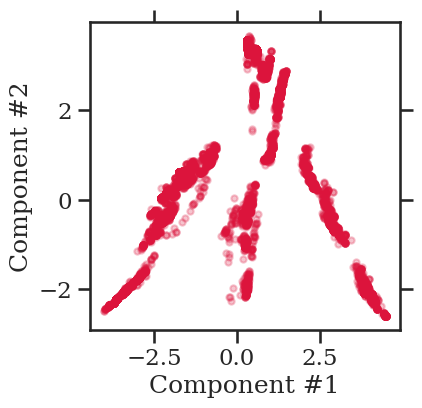

In [1764]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(components[:, 0], components[:, 1 ], s=20, c='crimson', alpha=0.25)
_ = ax.set(xlabel="Component #1", ylabel="Component #2")
plt.show()
plt.close()

---

### Cluster

cluster the shapley values of the weather-related observations with Birch

In [1765]:
clusterer = Birch(**clusterer_kwargs).fit(explanation.values[widx])

In [1766]:
clusterer

Birch(n_clusters=7, threshold=0.25)

extract cluster labels

In [1767]:
cluster = Series(clusterer.labels_,  name='cluster', index=widx)

In [1768]:
X_mean = X.groupby(cluster).mean()

cluster_labels = {}
for c in ['obscuration', 'thunderstorms', 'speed', 'snow', 'clouds', 'ceiling']:
    
    if c in ['visibility', 'ceiling']:
        idx = X_mean[c].idxmin()
    else:
        idx = X_mean[c].idxmax()

    cluster_labels[int(idx)] = c
    X_mean.drop(idx, inplace=True)

In [1769]:
cluster = cluster.map(cluster_labels).fillna('other')

In [1770]:
cluster.value_counts(normalize=True, dropna=False)

obscuration      0.392128
clouds           0.228301
ceiling          0.106330
speed            0.101116
thunderstorms    0.079674
other            0.052798
snow             0.039653
Name: cluster, dtype: float64

plot clusters in the projection

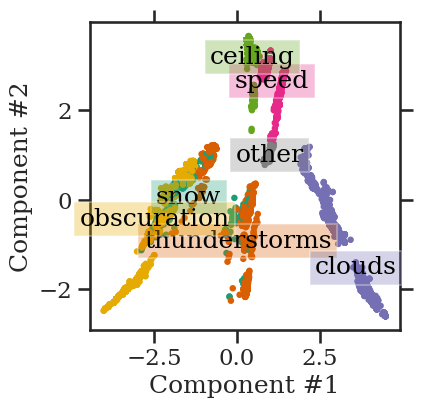

In [1780]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.scatter(components[:, 0], components[:, 1 ], s=10, c=cluster.map(palette_clusters))
_ = ax.set(xlabel="Component #1", ylabel="Component #2")

for k, v in palette_clusters.items():
    examples = components[where(cluster==k)]
    center = mean(examples, axis=0)
    
    if k == 'obscuration':
        t = ax.text(*center, s=str(k), c='black', ha='center', va='bottom')
        t.set_bbox(dict(facecolor=v, alpha=0.3, edgecolor=None))
    elif k == 'thunderstorms':
        t = ax.text(*center, s=str(k), c='black', ha='center', va='top')
        t.set_bbox(dict(facecolor=v, alpha=0.3, edgecolor=None))
    else:
        t = ax.text(*center, s=str(k), c='black', ha='center', va='center')
        t.set_bbox(dict(facecolor=v, alpha=0.3, edgecolor=None))
    
plt.show()
plt.close()

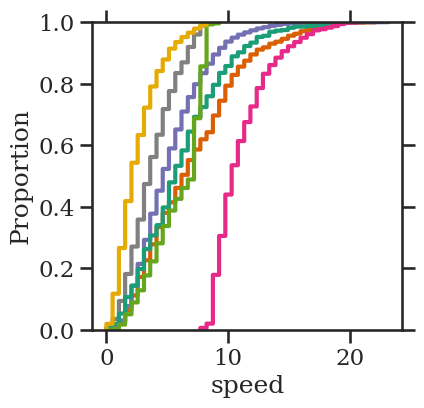

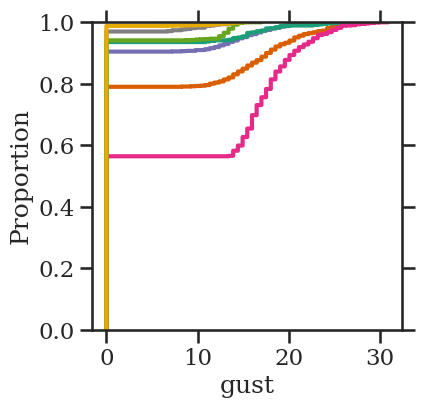

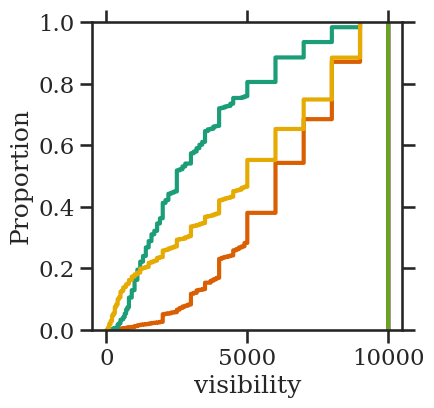

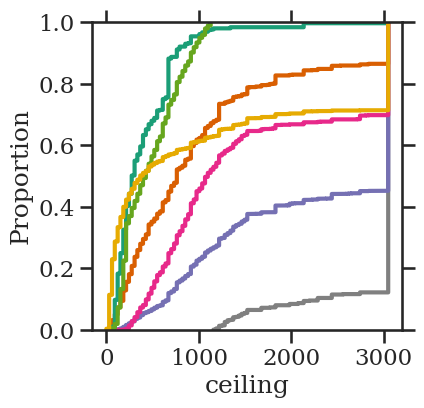

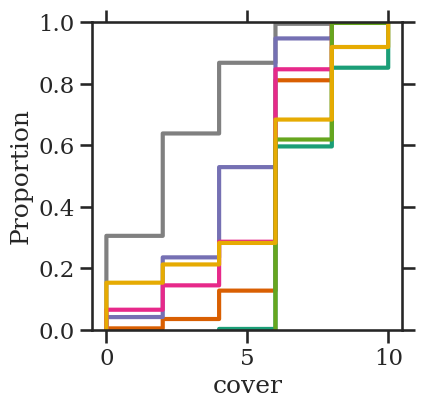

In [1781]:
for c in X.select_dtypes("number"):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = sns.ecdfplot(x=X[c].iloc[widx], 
                      hue=cluster,  
                      ax=ax, 
                      linewidth=3,
                      palette=palette_clusters, 
                      legend=False)
    
    plt.show()
    plt.close()

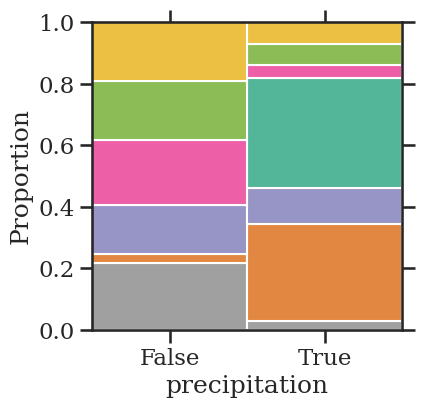

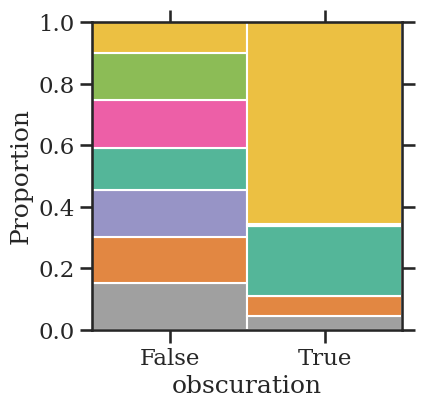

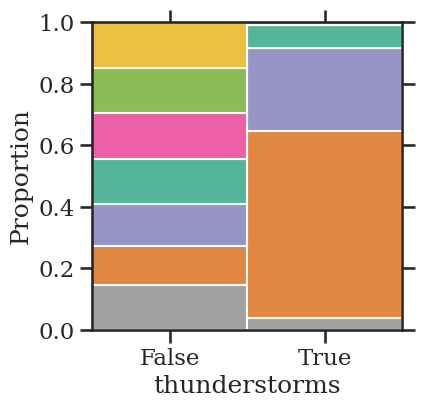

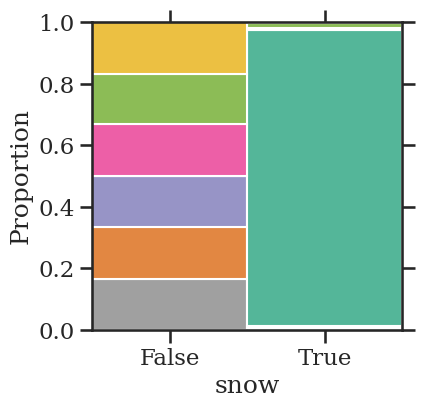

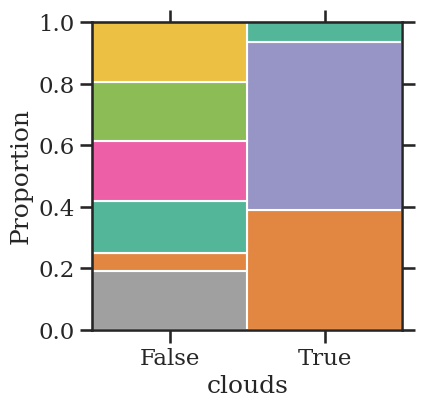

In [1782]:
for c in X.select_dtypes("bool"):
    fig, ax = plt.subplots(figsize=(4,4))
    
    ax = sns.histplot(x=X[c].sort_values().astype(str).iloc[widx], 
                        hue=cluster, 
                        ax=ax, 
                        multiple='fill', 
                        common_norm=False, 
                        palette=palette_clusters, 
                        legend=False,
                        shrink=True,
                        stat="proportion")
    
    plt.show()
    plt.close()

In [1783]:
Series(self_training_model.predict_proba(X)[:, 1], index=X.index).iloc[widx].groupby(cluster).mean()

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


cluster
ceiling          0.863337
clouds           0.943169
obscuration      0.960041
other            0.041807
snow             0.994218
speed            0.905995
thunderstorms    0.962019
dtype: float64

In [1784]:
X['reason'] = reason
X['cluster'] = cluster

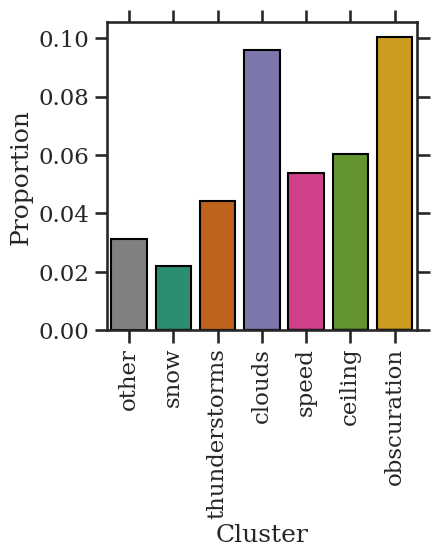

In [1785]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(x=X.cluster,
            y=fuel / fuel.sum(), 
            ax=ax,
            hue=X.cluster,
            order=palette_clusters.keys(),
            palette=palette_clusters, 
            estimator="sum", 
            dodge=False,
            edgecolor='black',
            errorbar=None)
ax.tick_params(axis='x', rotation=90)
plt.legend([],[], frameon=False)
ax.set_xlabel('Cluster')
ax.set_ylabel('Proportion')
plt.show()
plt.close()